In [1]:
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("darkgrid")
import scipy
from scipy import stats
from scipy import signal
sns.plt = plt
np.random.seed(1) # No estoy seguro si es necesario

mail = """
Hola a todos

Varios me preguntaron del formato de los archivos .mat

Cada .mat corresponde a un paciente y contiene una matriz tridimensional: trials/epochs x electrodos x muestras en Epoch

Por ejemplo, El archivo P01 tiene 864 epochs (primer dimensión). Eso quiere decir que de los 1200 ensayos que se hicieron con ese paciente solo 864 sobrevivieron al filtrado y preprocesamiento.

Espero que esto aclare un poco...


"""


In [2]:
mat = scipy.io.loadmat('datos/P01.mat')
mm = mat['data']

# Epoch = sonidito
# Electrodos = 256
# Tiempos = 201
# Epoch = 894
# Epochs  x Electrodos  x Tiempo
print mm[0][0][0]
print mm.shape


9.5019053032e-06
(894, 256, 201)


In [3]:
#
# a) Computar uno de los posibles análisis espectrales.

# a.1) Calcular la media entre los electrodos 8, 44, 80, 131 y 185 (el primer electrodo es el 0) 
# y realizar una figura que muestre las frecuencias en el eje Y, los epochs en el eje X
# , y la potencia usando una escala de color como en el ejemplo:


In [4]:
electrodo8 = mm[:, 7, :]
electrodo44 = mm[:, 43, :]
electrodo80 = mm[:, 79, :]
electrodo131 = mm[:, 130, :]
electrodo185 = mm[:, 184, :]

electrodos = [electrodo8, electrodo44, electrodo80, electrodo131, electrodo185]


In [5]:
def averageTimeSeries(tsList):
    for i in range(len(tsList[0])):
        yield np.mean(map(lambda ts: ts[i], tsList))

def averageInEpoch(epoch_idx):
    return averageTimeSeries(map(lambda electrodo: electrodo[epoch_idx], electrodos))


def senal_suavizada(ts):
    return ts
    return pd.ewma(pd.Series(ts), com=5.0)


In [6]:
averagedElectrodesByEpoch = [list(senal_suavizada(averageInEpoch(i))) for i in range(894)] 
# Primer Epoch

plt.show()


#data={'epoca': range(894),
#      'frequ': epoch0_welch[0]
#      'pot'  : [epoch0_welch[1], epoch1_welch[1], ]
#     } 

#averagedEpochs = pd.DataFrame(data=data, columns=['epochs', 'frecuencas', 'potencias'])

def freq_pots_relevantes(freqs, pots):
    pairs_relevantes = filter(lambda x: x[0] <= 45.0, zip(freqs, pots))
    freqs_relevantes = map(lambda x: x[0], pairs_relevantes)
    amplitudes_relevantes = map(lambda x: x[1], pairs_relevantes)
    return (freqs_relevantes, amplitudes_relevantes)
    

allEpochs = pd.DataFrame();
for i in range(894):
    epoch_welch = scipy.signal.welch(averagedElectrodesByEpoch[i], fs=250)
    frecuencas_sampleadas = epoch_welch[0]; # Deberia ser siempre lo mismo
    (freqs_relevantes, pots_relevantes) = freq_pots_relevantes(frecuencas_sampleadas, epoch_welch[1])
    allEpochs = allEpochs.append(pd.DataFrame(pots_relevantes).transpose());
    
allEpochs = allEpochs.reset_index();

print allEpochs

# No se por que aparece mil veces el dataframe printeado
# Arreglar eso
# crei que los ';' lo arreglaban pero no

/usr/local/lib/python2.7/site-packages/scipy/signal/spectral.py:1637: UserWarning: nperseg = 256 is greater than input length  = 201, using nperseg = 201
  .format(nperseg, input_length))


     index             0             1             2             3  \
0        0  2.203207e-12  5.521255e-12  3.325495e-12  1.694489e-12   
1        0  2.457573e-13  1.051716e-12  3.047509e-12  1.783282e-12   
2        0  5.591093e-13  2.805725e-12  9.683758e-13  4.742076e-13   
3        0  2.496316e-13  1.728102e-12  5.787040e-13  1.412563e-13   
4        0  1.456469e-12  7.779524e-12  4.328727e-12  9.029027e-13   
5        0  3.804657e-13  2.109862e-12  2.658752e-13  6.690450e-13   
6        0  1.590263e-12  8.384072e-12  4.296923e-12  9.712062e-13   
7        0  1.267426e-14  1.740605e-12  1.328269e-12  1.731006e-12   
8        0  1.465441e-12  8.379248e-12  4.939387e-12  4.486714e-13   
9        0  1.022471e-12  2.028634e-12  1.621861e-12  1.809199e-12   
10       0  6.033670e-13  2.539849e-12  3.941140e-13  1.639532e-13   
11       0  3.103675e-13  2.194586e-12  4.383132e-13  8.981081e-15   
12       0  3.528304e-13  5.439483e-13  4.697625e-13  8.685813e-13   
13       0  7.511063

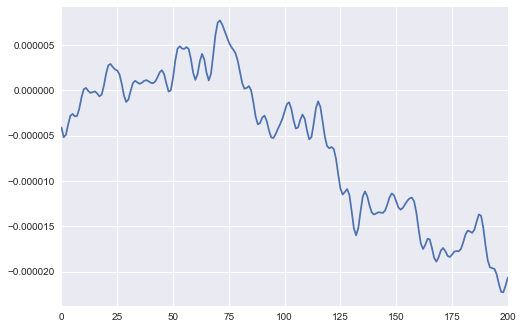

In [7]:

# Viendo este grafico creo que habia que suavizar la funcion
# Capaz asi el grafico de arriba se pone mas interesante


sns.tsplot(averagedElectrodesByEpoch[20])
plt.show()

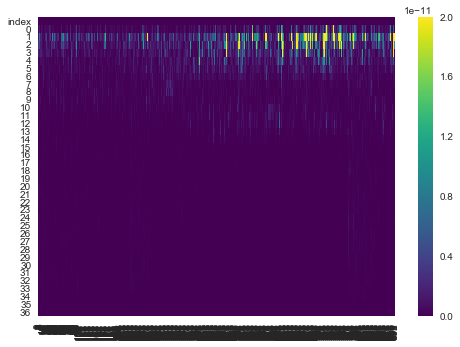

In [8]:
sns.heatmap(allEpochs.transpose(), cmap="viridis", vmax=2e-11 )
plt.show()



In [9]:
freqs_usadas_finales = None
def calc_potencias(electrodo_idx):
    def get_epoch(epoch_idx):
        epoch = mm[epoch_idx, electrodo_idx, :]
        return epoch
    def potencias_epoch(epoch_idx):
        welch_result = scipy.signal.welch(get_epoch(epoch_idx), fs=250)
        global freqs_usadas_finales
        (freqs_relevantes, pots_relevantes) = freq_pots_relevantes(welch_result[0], welch_result[1])
        freqs_usadas_finales = freqs_relevantes
        return pots_relevantes
    potencias = [potencias_epoch(i) for i in range(894)]
    res = []
    for i in range(len(potencias[0])):
        res.append(np.average([pot[i] for pot in potencias]))
    return res

In [10]:


colors = sns.color_palette("muted", n_colors=201)
potencias_electrodo = []
for i in range(200):
    potencias_electrodo.append(calc_potencias(i))



In [11]:
print freqs_usadas_finales

[0.0, 1.2437810945273631, 2.4875621890547261, 3.7313432835820892, 4.9751243781094523, 6.2189054726368154, 7.4626865671641784, 8.7064676616915406, 9.9502487562189046, 11.194029850746269, 12.437810945273631, 13.681592039800993, 14.925373134328357, 16.169154228855721, 17.412935323383081, 18.656716417910445, 19.900497512437809, 21.144278606965173, 22.388059701492537, 23.631840796019898, 24.875621890547261, 26.119402985074625, 27.363184079601986, 28.60696517412935, 29.850746268656714, 31.094527363184078, 32.338308457711442, 33.582089552238806, 34.825870646766163, 36.069651741293526, 37.31343283582089, 38.557213930348254, 39.800995024875618, 41.044776119402982, 42.288557213930346, 43.53233830845771, 44.776119402985074]


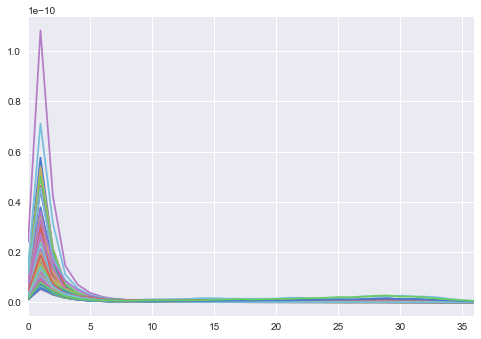

In [12]:

for i in range(200):
    sns.tsplot(potencias_electrodo[i], color=colors[i])
plt.show()

In [13]:
potencias_promedio = [np.average([pot[i] for pot in potencias_electrodo ]) for i in range(len(potencias_electrodo[0]))]

In [14]:
print potencias_promedio

[2.8870109728898942e-12, 1.4022475132621775e-11, 6.3748510132892206e-12, 3.0178767765881515e-12, 1.8255740063061053e-12, 1.1757129929191992e-12, 7.4279733214882291e-13, 5.3965120179067024e-13, 4.2856593639310924e-13, 3.9741587762763603e-13, 4.2392255862702202e-13, 3.3052503402534374e-13, 2.6452143983104499e-13, 2.2241657307239012e-13, 1.9691563881358547e-13, 1.8102655284626709e-13, 1.6801927090973569e-13, 1.6190058162431188e-13, 1.5743982697169304e-13, 1.6238982785183211e-13, 1.7084803145692925e-13, 1.7931725007388349e-13, 1.7423871923190482e-13, 1.6629194993828145e-13, 1.7680784573140061e-13, 1.8034909918238684e-13, 1.7876671947718489e-13, 1.9260871473569553e-13, 1.918064017054828e-13, 1.9203311350900265e-13, 1.8799396041675457e-13, 1.7827697152530979e-13, 1.6274574469912347e-13, 1.4136016322900896e-13, 1.073026559173484e-13, 7.2954085189484526e-14, 4.5761580751653749e-14]


In [15]:
def potencia_banda(low, high):
    # Thomas dice np.average 
    return np.average(map(lambda x: x[0], filter(lambda x: x[1] >= low and x[1] < high, zip(potencias_promedio, freqs_usadas_finales))))

In [16]:
banda_delta = potencia_banda(0., 4.0)
banda_theta = potencia_banda(4.0, 8.0)
banda_alpha = potencia_banda(8.0, 13.0)
banda_beta = potencia_banda(13.0, 30.)
banda_gamma = potencia_banda(30.0, 125.)
print banda_delta
print banda_theta
print banda_alpha
print banda_beta
print banda_gamma

6.57555347385e-12
1.24802811046e-12
4.4738889361e-13
1.93761324456e-13
1.52663267528e-13


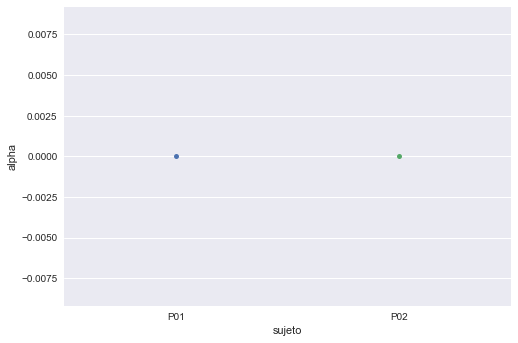

In [23]:
alpha_frame = pd.DataFrame(data=[{"alpha":banda_alpha,"sujeto":"P01"}, {"alpha":banda_alpha+1e-13,"sujeto":"P02"}], columns=['alpha','sujeto'])
sns.stripplot(data=alpha_frame, y="alpha", x="sujeto")

plt.show()

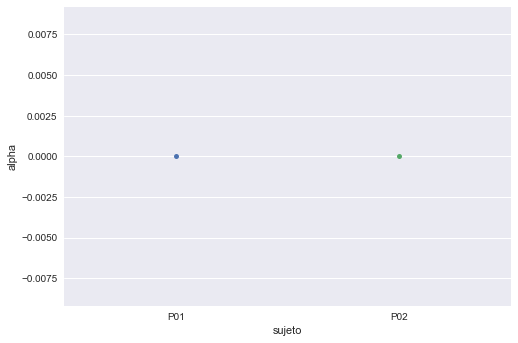

In [24]:
sns.swarmplot(x="sujeto", y="alpha", data=alpha_frame)
plt.show()

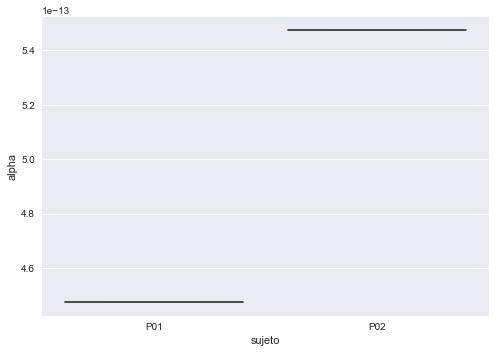

In [25]:
sns.boxplot(x="sujeto", y="alpha", data=alpha_frame)
plt.show()

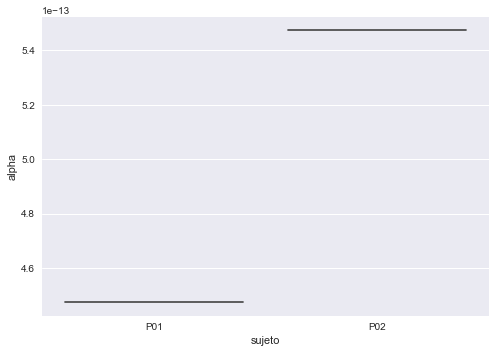

In [26]:
sns.violinplot(x="sujeto", y="alpha", data=alpha_frame)
plt.show()

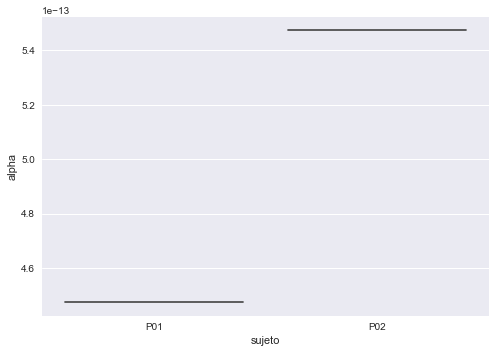

In [27]:
sns.lvplot(x="sujeto", y="alpha", data=alpha_frame)
plt.show()

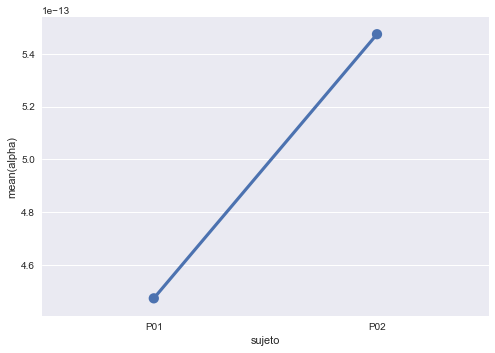

In [28]:
sns.pointplot(x="sujeto", y="alpha", data=alpha_frame)
plt.show()

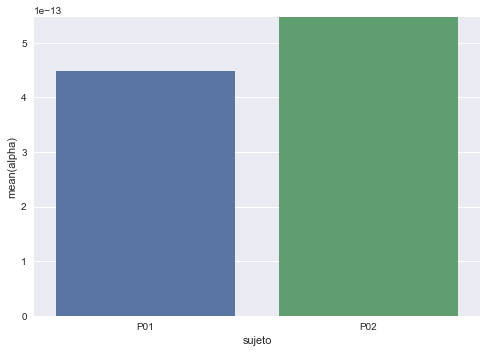

In [32]:
sns.barplot(x="sujeto", y="alpha", data=alpha_frame)
plt.show()

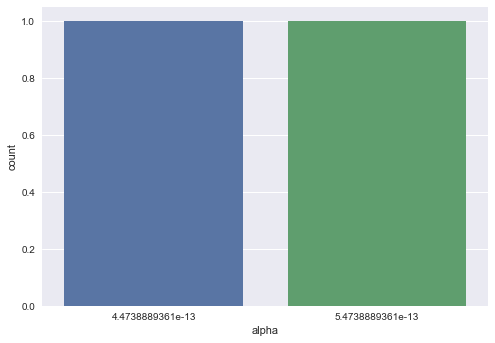

In [36]:
sns.countplot(x="alpha", data=alpha_frame)
plt.show()